<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#FuncNode" data-toc-modified-id="FuncNode-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FuncNode</a></span><ul class="toc-item"><li><span><a href="#What-for?" data-toc-modified-id="What-for?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>What for?</a></span></li><li><span><a href="#What-can-FuncNode-do?" data-toc-modified-id="What-can-FuncNode-do?-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>What can <code>FuncNode</code> do?</a></span></li><li><span><a href="#What's-with-the-names?" data-toc-modified-id="What's-with-the-names?-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>What's with the names?</a></span></li></ul></li><li><span><a href="#A-DAG" data-toc-modified-id="A-DAG-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A DAG</a></span><ul class="toc-item"><li><span><a href="#Extending-an-existing-dag" data-toc-modified-id="Extending-an-existing-dag-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Extending an existing dag</a></span></li></ul></li><li><span><a href="#Example:-Evaluating-a-classifier" data-toc-modified-id="Example:-Evaluating-a-classifier-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Example: Evaluating a classifier</a></span><ul class="toc-item"><li><span><a href="#classifier_score" data-toc-modified-id="classifier_score-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>classifier_score</a></span></li><li><span><a href="#Making-it-more-useful" data-toc-modified-id="Making-it-more-useful-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Making it more useful</a></span></li><li><span><a href="#Making-the-DAG-bigger" data-toc-modified-id="Making-the-DAG-bigger-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Making the DAG bigger</a></span></li><li><span><a href="#Getting-a-sub-dag" data-toc-modified-id="Getting-a-sub-dag-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Getting a sub-dag</a></span></li></ul></li><li><span><a href="#Scrap" data-toc-modified-id="Scrap-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scrap</a></span></li></ul></div>

# Intro

In [99]:
from meshed import DAG

def this(a, b=1):
    return a + b
def that(x, b=1):
    return x * b
def combine(this, that):
    return (this, that)

dag = DAG((this, that, combine))
print(dag.synopsis_string())

x,b -> that_ -> that
a,b -> this_ -> this
this,that -> combine_ -> combine


But what does it do?

It's a callable, with a signature:

In [100]:
from inspect import signature
signature(dag)

<Signature (x, a, b=1)>

And when you call it, it executes the dag from the root values you give it and
returns the leaf output values.

In [102]:
dag(1, 2, 3)  # (a+b,x*b) == (2+3,1*3) == (5, 3)

(5, 3)

In [103]:
dag(1, 2)  # (a+b,x*b) == (2+1,1*1) == (3, 1)

(3, 1)

You can see (and save image, or ascii art) the dag:

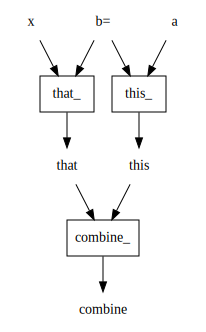

In [110]:
dag.dot_digraph()

You can extend a dag

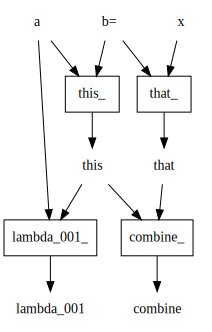

In [117]:
dag2 = DAG([*dag, lambda this, a: this + a])
dag2.dot_digraph()

You can get a sub-dag by specifying desired input(s) and outputs.

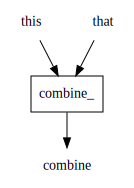

In [126]:
dag2[['that', 'this'], 'combine'].dot_digraph()

# FuncNode

In [1]:
from meshed import FuncNode

## What for?

Say you have a function to multiply numbers

In [2]:
def multiply(x, y):
    return x * y

And you use it in some code like this:

In [3]:
item_price = 3.5
num_of_items = 2
total_price = multiply(item_price, num_of_items)

What the execution of `total_price = multiply(item_price, num_of_items)` does is
- grab the values (in the locals scope -- a dict), of ``item_price`` and ``num_of_items``,
- call the multiply function on these, and then
- write the result to a variable (in locals) named ``total_price``

`FuncNode` is a function wrapper that specification of such a `output = function(...inputs...)` assignment statement 
in such a way that it can carry it out on a `scope`. A `scope` is a `dict` where the function can find it's input values and write it's output values 
(if the user so chooses). 

For example, the `FuncNode` form of the above statement would be:

In [4]:
func_node = FuncNode(
    func=multiply, 
    bind={'x': 'item_price', 'y': 'num_of_items'}, 
)
func_node

FuncNode(item_price,num_of_items -> multiply_ -> multiply)

Note the `bind` is a mapping **from** the variable names of the wrapped function **to** the names of the scope.

That is, when it's time to execute, it tells the `FuncNode` where to find the values of its inputs. 

If an input is not specified in this `bind` mapping, the scope (external) name is supposed to be the same as the function's (internal) name.

## What can `FuncNode` do?

The purpose of a `FuncNode` is to source some inputs somewhere, compute something
with these, and write the result somewhere. That somewhere is what we call a
scope. 

A scope is a dictionary (or any mutuable mapping to be precise) and it works
like this:

In [5]:
scope = {'item_price': 3.5, 'num_of_items': 2}
func_node(scope)  # returns 7.0

7.0

In [6]:
scope  # and 7.0 was written in the scope

{'item_price': 3.5, 'num_of_items': 2, 'multiply': 7.0}

## What's with the names?

Consider ``item_price,num_of_items -> multiply_ -> multiply``.

See that the name of the function is used for the name of its output,
and an underscore-suffixed name for its function name.

That's the default behavior if you don't specify either a name (of the function)
for the `FuncNode`, or a `output_name`.

The underscore is to distinguish from the name of the function itself.

The function gets the underscore because this favors particular naming style. 

The

```
item_price,num_of_items -> multiply_ -> total_price
```

shows you what the `FuncNode` node looks like on the outside. Note the `multiply_` with the underscore. 
That's the default name the `FuncNode` gave to the function. The underscore is to distinguish from the name of the function itself. 

You can give it a custom name as well:

In [9]:
FuncNode(
    func=multiply, 
    bind={'x': 'item_price', 'y': 'num_of_items'}, 
    out='daily_expense'
)

FuncNode(item_price,num_of_items -> multiply -> daily_expense)

In [11]:
FuncNode(
    func=multiply, 
    name='total_price',
    bind={'x': 'item_price', 'y': 'num_of_items'}, 
)

FuncNode(item_price,num_of_items -> total_price -> _total_price)

In [12]:
FuncNode(
    func=multiply, 
    name='total_price',
    bind={'x': 'item_price', 'y': 'num_of_items'}, 
    out='daily_expense'
)

FuncNode(item_price,num_of_items -> total_price -> daily_expense)

Note: In the context of networks if you want to reuse a same function (say, `multiply`) in multiple places 
you'll **need** to give it a custom name because the functions are identified by this name in the network. 

Note: These default name rules are determined by (and therefore can be changed through) the `names_maker` argument of `FuncNode`.

# A DAG

A DAG (Direct Acyclic Graph) is determined by a bunch of `FuncNode`s. 

The `FuncNode`s alone determine what computations can take place and how these computation units interact with each other, 
and even what names are used by the interface of the DAG.

Therefore you can control all those aspects by specifying what you want in the `FuncNode`s. 

In [13]:
def add(x, y):
    return x * y

def mul(x, y):
    return x * y

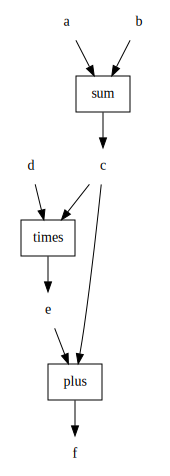

In [14]:
from meshed import DAG, FuncNode

dag = DAG(
    [
        FuncNode(add, 'sum',   {'x': 'a', 'y': 'b'}, 'c'),
        FuncNode(mul, 'times', {'x': 'c', 'y': 'd'}, 'e'),
        FuncNode(add, 'plus',  {'x': 'c', 'y': 'e'}, 'f'),
    ]
)
dag.dot_digraph()

In [15]:
dag(a=1, b=2, d=3)  # ((a + b) * d) + (a + b) = ((1 + 2) * 3) + (1 + 2) = 12

12

Note two things in the example above.

We reused `add` twice, but gave it a different name both times.

The functions all had the same input names (`x` and `y`), 
but these were mapped to other names which determined the dag's argument names (`a`, `b` and `d`) 
and computational flow (the `c` routing the output of `sum` to `times` and `plus`).

But as long as there are no name conflicts, there's a same bag of functions will result in the same unique `DAG`.

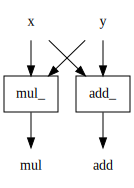

In [16]:
DAG([add, mul]).dot_digraph()

## Extending an existing dag

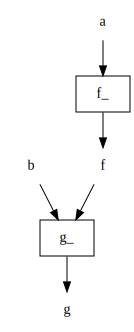

In [17]:
def f(a): return a * 2
def g(f, b): return f + b
    
dag = DAG([f, g])
dag.dot_digraph()

In [18]:
assert dag(2, 3) == 7
dag(a=2, b=3)  # a * 2 + b = 2 * 2 + 3 = 7

7

In [19]:
def h(a, b, g): return f"{a=} {b=} {g=}"
extended_dag = DAG([*dag, h])
assert extended_dag(a=2, b=3) == 'a=2 b=3 g=7'
extended_dag(a=2, b=3)

'a=2 b=3 g=7'

# Example: Evaluating a classifier

We'd like to develop some tools that will help a user to make a domain-specific metric (DSM) to evaluate binary classifiers.

Often, off-the-shelf metrics are used, such as accuracy, precision, recall, false-positive-rate, etc. 

The number these produce may not be directly interpretable in the domain they're being applied to. 

It can be helpful to see what false negative, false positive, etc. mean in the given context, 
and associate a value (penalty or reward) to these 
that reflects how much they contribute towards or contravene the actual objective of the classifier. 

If a COVID test turns out positive, what actions will be taken and what value do their consequences have depending on whether the positive test 
was true or false? Same question for true/false negative test results. Doing this valuation then allows us to produce a formula that
evaluates the worth of a test that has more meaning that flat false positive and false negative rates. 


##  classifier_score

In [20]:
def _aligned_items(a, b):
    """Yield (k, a_value, b_value) triples for all k that are both a key of a and of b"""
    # reason for casting to dict is to make sure things like pd.Series use the right keys.
    # could also use k in a.keys() etc. to solve this.
    a = dict(a)
    b = dict(b)
    for k in a:
        if k in b:
            yield k, a[k], b[k]
            
def dot_product(a, b):
    """
    >>> dot_product({'a': 1, 'b': 2, 'c': 3}, {'b': 4, 'c': -1, 'd': 'whatever'})
    5
    """
    return sum(ak * bk for _, ak, bk in _aligned_items(a, b))


def classifier_score(confusion_count, confusion_value):
    """Compute a score for a classifier that produced the `confusion_count`, based on the given `confusion_value`.
    Meant to be curried by fixing the confusion_value dict.
    
    The function is purposely general -- it is not specific to binary classifier outcomes, or even any classifier outcomes. 
    It simply computes a normalized dot product, depending on the inputs keys to align values to multiply and 
    considering a missing key as an expression of a null value. 
    """
    return dot_product(confusion_count, confusion_value) / sum(confusion_count.values())


In [21]:
dot_product({'a': 1, 'b': 2, 'c': 3}, {'b': 4, 'c': -1, 'd': 'whatever'})

5

In [22]:
# tp, fp, fn, tn shorthands for true positive, false positive, false nagative and true nagative
confusion_count = {'tp': 30, 'fp': 10, 'fn': 2, 'tn': 8}
confusion_value = {'tp': 0, 'fp': -1, 'fn': -5, 'tn': 0}

print(f"{dot_product(confusion_count, confusion_value)=}, {sum(confusion_count.values())=}")
classifier_score(confusion_count, confusion_value)

dot_product(confusion_count, confusion_value)=-20, sum(confusion_count.values())=50


-0.4

See how accuracy can be expressed by setting values of true positive and negative to 1, and zero for all errors:

In [23]:
confusion_value = {'tp': 1, 'fp': 0, 'fn': 0, 'tn': 1}  # this corresponds to the accuracy metric!
classifier_score(confusion_count, confusion_value)

0.76

## Making it more useful

To make it more readily usable, we should offer ways to easily get a `confusion_count` dict from various common situations. 

For example, how do we get these `confusion_count`? Possibly from an array of predictions and corresponding truths.

```
truth, prediction -> confusion_count
```

These predictions might come from an array `predict_prob` of scores that were thresholded to become a binary value that we call our prediction.

```
predict_proba, threshold -> prediction
```

And those `predict_proba` scores themselves might come from a trained model who is fed `test_X` inputs, the `test_y` array being this `truth` 
that we're talking about. 

```
model, test_X -> predict_proba
test_y -> truth
```

Providing the user with a few util tools 
to get from where they are (e.g. they have a model and some test data) 
to where they want to get to (e.g. getting a classifier_score)
is nice.

Making it clear on how to use these functions to get from A to B is also nice.
This can be done through documentation, examples, and (Uncle Bob style) through careful function and variable naming, as below.

In [24]:
from collections import Counter
import numpy as np


def confusion_count(prediction, truth):
    """Get a dict containing the counts of all combinations of predicction and corresponding truth values.

    >>> confusion_count(
    ... [0, 0, 1, 0, 1, 1, 1], 
    ... [0, 0, 0, 1, 1, 1, 1]
    ... )
    Counter({(0, 0): 2, (1, 0): 1, (0, 1): 1, (1, 1): 3})
    """
    return Counter(zip(prediction, truth))


def prediction(predict_proba, threshold):
    """Get an array of predictions from thresholding the scores of predict_proba array.

    >>> prediction([0.3, 0.4, 0.5, 0.6, 0.7, 0.8], threshold=0.5)
    array([False, False,  True,  True,  True,  True])

    """
    return np.array(predict_proba) >= threshold


def predict_proba(model, test_X):
    """Get the prediction_proba scores of a model given some test data"""
    return model.predict_proba(test_X)

Conveniently, if we use names of functions and arguments as we did above, these can be used to indicate how they all relate to each other. 

That is to say, we need nothing further to make a DAG.

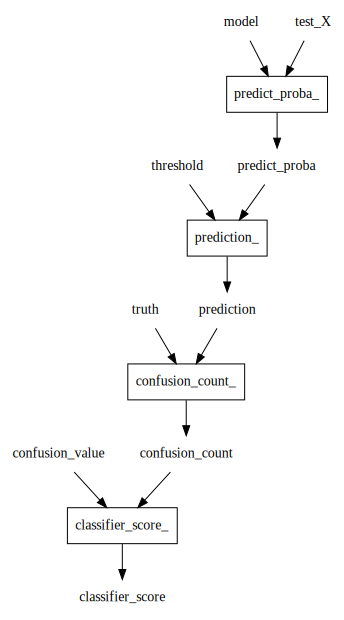

In [25]:
from meshed import DAG

dag = DAG([classifier_score, confusion_count, prediction, predict_proba])
dag.dot_digraph()

## Making the DAG bigger

And how did we get those top inputs (`model`, `test_X` and `test_y`)? 

Well, we trained a learner on some `train_X` and `train_y` that we get by splitting some `(X, y)` arrays...

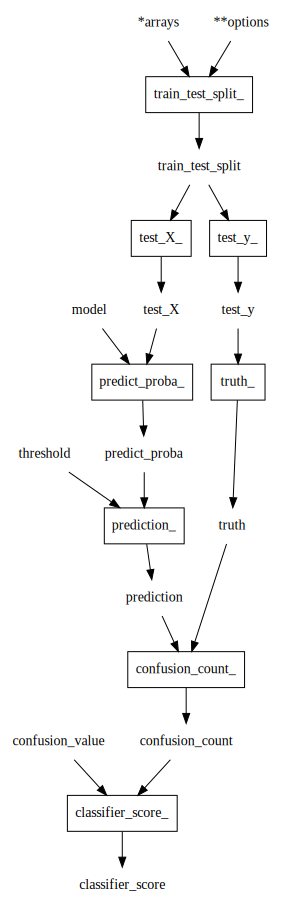

In [26]:
from sklearn.model_selection import train_test_split
from meshed import FuncNode
# from operator import itemgetter

# train_X, test_X, train_y, test_y = train_test_split(...)

def test_X(train_test_split):
    return train_test_split[1]

def test_y(train_test_split):
    return train_test_split[3]

def truth(test_y):  # to link up truth and test_y
    return test_y

# Note how we extend the existing dag by adding a few functions:
bigger_dag = DAG([*dag,  train_test_split, test_X, test_y, truth])
bigger_dag.dot_digraph()

## Getting a sub-dag

The current `bigger_dag` will get you `classifier_score` from input `model`, `threshold`, `confusion_value`, `arrays` and (optional) `options`. 

But what if you just wanted the `confusion_count`, and you already had the `predict_proba` and `truth` arrays?

Well, you can ask for `bigger_dag` to give you a sub-dag of your choice. We chose to use brackets `[...]` as the interface to get sub-dags, 
reminiscent of getting a sub-array of a numpy array or a sub-dataframe from a pandas dataframe. 

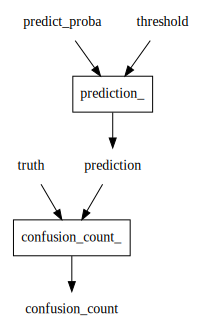

In [27]:
f = bigger_dag[['threshold', 'predict_proba'], 'confusion_count']
f.dot_digraph()

Let's see what `bigger_dag[['threshold', 'predict_proba'], 'confusion_count']` means.

Here we're asking to get a function (a dag really) that will get us from `threshold` and `predict_proba` inputs to the value of `confusion_count`. 

But you'll notice that you get a function that has three arguments, not two:

In [29]:
from i2 import Sig  # i2 comes with meshed
Sig(f)

<Sig (predict_proba, threshold, truth)>

That's because `threshold` and `predict_proba` are not sufficient to get you the `confusion_count`.

What you actually get is smallest set of input arguments containing the ones you requested that will actually get you to the outputs you requested

So to get a sub-dag, you say `dag[input_args, output_args]`.

Both `input_args` and `output_args` can be 
- a single argument
- a list of arguments
- an empty slice (i.e. `:`), which means "no condition", i.e. "all possible" (inputs or outputs)

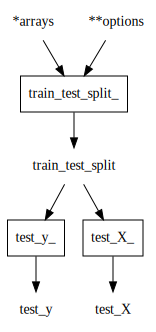

In [30]:
f = bigger_dag[:, ['test_X', 'test_y']]
f.dot_digraph()

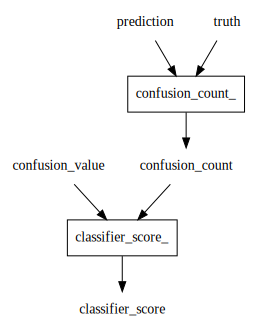

In [31]:
f = bigger_dag['prediction', :]
f.dot_digraph()

You can also specify your desired inputs and outputs as functions (if only used by a unique node) or func_node name. 

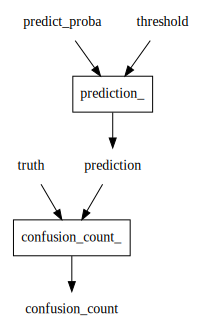

In [84]:
bigger_dag['prediction_', confusion_count].dot_digraph()

Make sure you understand the difference/equivalent between the above and the two following:

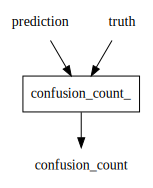

In [87]:
bigger_dag['prediction', confusion_count].dot_digraph()

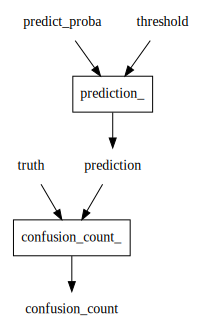

In [90]:
bigger_dag[prediction, confusion_count].dot_digraph()  

Above we used `prediction`, the function -- not `'prediction'`, the string, which indicates the output of `prediction`.

If we wanted to specify the `prediction` function we a string, we should use the func_node name:  `'prediction_'`.

In [57]:
bigger_dag[:, 'classifier_score_'].dot_digraph()

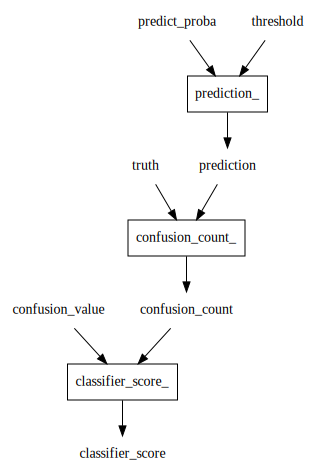

In [35]:
f = bigger_dag[['threshold', 'predict_proba', 'truth'], :]
f.dot_digraph()

# Scrap

In [35]:
from typing import Any, Mapping, Sized, MutableMapping, Iterable
from meshed.itools import children, parents


def coparents_sets(g: Mapping, source: Iterable):
    res = []
    for node in source:
        for kid in children(g, [node]):
            res.append(frozenset(parents(g, [kid])))
    return set(res)


def known_parents(g: Mapping, kid, source):
    return parents(g, [kid]).issubset(set(source))


def list_coparents(g: Mapping, coparent):
    all_kids = children(g, [coparent])
    result = [parents(g, [kid]) for kid in all_kids]

    return result


def kids_of_united_family(g: Mapping, source: Iterable):
    res = set()
    for coparent in source:
        for kid in children(g, [coparent]):
            if known_parents(g, kid, source):
                res.add(kid)
    return res


def extended_family(g: Mapping, source: Iterable):
    res = set(source)
    while True:
        allowed_kids = kids_of_united_family(g, res)
        if allowed_kids.issubset(res):
            return res
        res = res.union(allowed_kids)


def funcnode_only(source: Iterable):
    return [item for item in source if isinstance(item, FuncNode)]


def dag_from_funcnodes(dag, input_names):
    kids = extended_family(g=dag.graph, source=input_names)
    fnodes = funcnode_only(kids)

    return DAG(fnodes)

In [36]:
d = bigger_dag

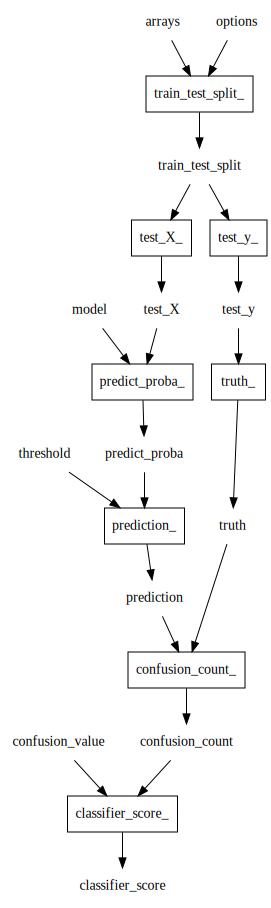

In [37]:
d.dot_digraph()

In [43]:
dd = dag_from_funcnodes(d, ['theshold', 'predict_proba', 'truth'])
dd.dot_digraph()

In [41]:
extended_family(d.graph, ['prediction', 'truth'])

{FuncNode(prediction,truth -> confusion_count_ -> confusion_count),
 'confusion_count',
 'prediction',
 'truth'}

In [47]:
g = d.graph

In [59]:
from functools import partial
is_func_node = lambda x: isinstance(x, FuncNode)
t = list(filter(is_func_node, descendants(g, ['train_test_split'])))
t

[FuncNode(train_test_split -> test_X_ -> test_X),
 FuncNode(train_test_split -> test_y_ -> test_y),
 FuncNode(prediction,truth -> confusion_count_ -> confusion_count),
 FuncNode(test_y -> truth_ -> truth),
 FuncNode(predict_proba,threshold -> prediction_ -> prediction),
 FuncNode(confusion_count,confusion_value -> classifier_score_ -> classifier_score),
 FuncNode(model,test_X -> predict_proba_ -> predict_proba)]

In [60]:
tt = list(filter(is_func_node, ancestors(g, ['prediction'])))
tt

[FuncNode(train_test_split -> test_X_ -> test_X),
 FuncNode(arrays,options -> train_test_split_ -> train_test_split),
 FuncNode(predict_proba,threshold -> prediction_ -> prediction),
 FuncNode(model,test_X -> predict_proba_ -> predict_proba)]

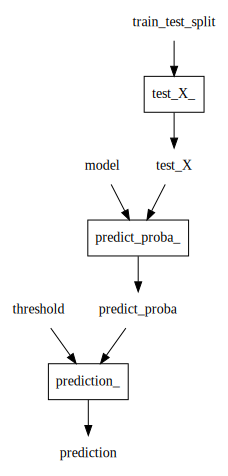

In [64]:
DAG(set(t).intersection(tt)).dot_digraph()

In [81]:
list(d)

[FuncNode(arrays,options -> train_test_split_ -> train_test_split),
 FuncNode(train_test_split -> test_y_ -> test_y),
 FuncNode(test_y -> truth_ -> truth),
 FuncNode(train_test_split -> test_X_ -> test_X),
 FuncNode(model,test_X -> predict_proba_ -> predict_proba),
 FuncNode(predict_proba,threshold -> prediction_ -> prediction),
 FuncNode(prediction,truth -> confusion_count_ -> confusion_count),
 FuncNode(confusion_count,confusion_value -> classifier_score_ -> classifier_score)]

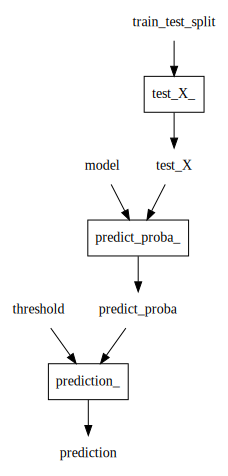

In [70]:
dd = d['train_test_split', 'prediction']
dd.dot_digraph()

In [72]:
Sig(dd)

<Sig (train_test_split, model, threshold)>

In [84]:
[x.name for x in d]

['train_test_split_',
 'test_y_',
 'truth_',
 'test_X_',
 'predict_proba_',
 'prediction_',
 'confusion_count_',
 'classifier_score_']

In [85]:
FuncNode(lambda x, y: x + y)

FuncNode(x,y -> <lambda>_ -> <lambda>)